# Vertical regridding and remapping of CMIP6 ocean data in the cloud
## C Spencer Jones, Julius Busecke, Takaya Uchida and Ryan Abernathey

In [1]:
#I will remove these in the final version: they are just useful for running and editting on pangeo
#conda install xarray=0.15.0
#conda install -c conda-forge xarrayutils

### Introduction

Many ocean and climate models output ocean variables (like velocity, temperature, oxygen concentration etc.) in depth space. Property transport in the ocean generally follows isopycnals, but isopycnals often move up and down in depth space. A small difference in the vertical location of isopycnals between experiments can cause a large apparent difference in ocean properties when the experiments are compared in depth space. As a result, it is often useful to compare ocean variables in density space. 

This work compares two algorithms for plotting ocean properties in density coordinates, one written in FORTRAN with a python wrapper ([xlayers](https://github.com/cspencerjones/xlayers)), and one written in xarray ([xarrayutils](https://github.com/jbusecke/xarrayutils)). Both algorithms conserve total salt content in the vertical, and both algorithms are easily parallelizable to enable plotting large datasets in density coordinates. As shown here, xlayers is a faster algorithm, but it requires more setup due to its reliance on a FORTRAN compiler.

Here, we apply these algorithms to plot salinity in density space in some of the CMIP-6 models. We compare the salinity as a function of density in  two future greenhouse-gas scenarios. In general, areas with net precipitation today are getting fresher and areas with net evaporation today are getting saltier ([Durack and Wijffels, 2010](https://doi.org/10.1175/2010JCLI3377.1)). In climate models with a 1% per year CO$_2$ increase, areas with net precipitation experience increasing precipitation, and areas with net evaporation today experience a further reduction in precipitation in higher greenhouse-gas scenarios ([Vallis et al. 2015](https://doi.org/10.1002/qj.2456)). Here we compare two different greenhouse gas scenarios in the Shared Socioeconomic Pathways experiments. By plotting salinity in density space, we visualize how changes in evaporation and precipitation at the surface propagate along isopycnals to influence salinity concentrations in the ocean interior. 

### Loading CMIP-6 data
We choose to load temperature and salinity data from the ACCESS-ESM1-5 model, but this calculation can be performed on almost any CMIP-6 model currently available through [Google's public datasets program](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets). 

In [2]:
#Load the packages needed
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import zarr
import gcsfs
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Access the catalog of available data
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

#Write a query to find specific variables 
df_sub = df.query("source_id == 'ACCESS-ESM1-5' and member_id=='r1i1p1f1' and table_id=='Omon' and (experiment_id=='ssp126' or experiment_id=='ssp585') and \
                            (variable_id=='thetao' or variable_id=='so')")
my_values = df_sub.zstore.values

We choose to compare properties for two future greenhouse gas scenarios, sometimes called [Shared Soceioeconomic Pathways](https://doi.org/10.1016/j.gloenvcha.2016.05.009). The first is a lower-emissions scenario, SSP1-2.6, and the second is a higher-emissions scenario, SSP5-8.5. The following code accesses the specific zarr stores that contain temperature and salinity data for these two pathways and sets up pointers to this data. 

In [4]:
# get the path to the specific zarr store that contains salinity for SSP1-2.6
zstore = my_values[0]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# open it using xarray and zarr
ds_so_ssp126 = xr.open_zarr(mapper, consolidated=True)

# get the path to the specific zarr store that contains temperature for SSP1-2.6
zstore = my_values[1]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# open it using xarray and zarr
ds_thetao_ssp126 = xr.open_zarr(mapper, consolidated=True)

# get the path to the specific zarr store that contains salinity for SSP5-8.5
zstore = my_values[2]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# open it using xarray and zarr
ds_so_ssp585 = xr.open_zarr(mapper, consolidated=True)

# get the path to the specific zarr store that contains temperature for SSP5-8.5
zstore = my_values[3]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# open it using xarray and zarr
ds_thetao_ssp585 = xr.open_zarr(mapper, consolidated=True)


The data in these stores is given in depth space. In order to plot the salinity in potential density coordinates, we need the potential density field in depth space. In the cell below, the gibbs seawater toolbox is applied to find the surface-referenced potential density from the temperature and salinity. The [ACCESS](10.22499/2.6301.004) model actually uses the [Jackett et al 2006](https://doi.org/10.1175/JTECH1946.1) equation of state, but the density calculated here is a good approximation of the density in the ACCESS model.

In [5]:
import gsw
dens126 = xr.apply_ufunc(gsw.density.sigma0, ds_so_ssp126['so'], ds_thetao_ssp126['thetao'],
                      dask='parallelized', output_dtypes=[float, ]
                     ).rename('dens').to_dataset()
dens585 = xr.apply_ufunc(gsw.density.sigma0, ds_so_ssp585['so'], ds_thetao_ssp585['thetao'],
                      dask='parallelized', output_dtypes=[float, ]
                     ).rename('dens').to_dataset()

We choose to study a meridional section in the Atlantic basin, which is plotted below. 

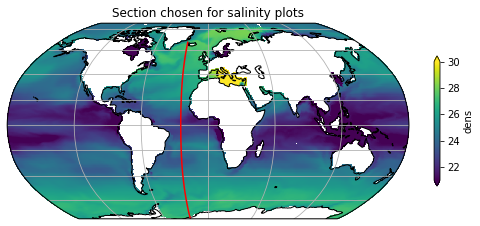

In [6]:
ssd = dens126.dens[0,0,:,:].rename({'longitude':'lon', 'latitude': 'lat'})
sss = ds_so_ssp585.so[0,0,:,:].rename({'longitude':'lon', 'latitude': 'lat'})
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ax.gridlines()
ssd.plot(x='lon',y='lat',ax=ax, transform=ccrs.PlateCarree(),
         vmin=21, vmax=30, cbar_kwargs={'shrink': 0.4})
ssd[:250,:].isel(i=255).lat.plot(x='lon',ax=ax, transform=ccrs.PlateCarree(),color='r')
ax.set_title('Section chosen for salinity plots');

These simulations begin in 2015. We choose to compare salinities in three different years: 2050, 2075 and 2100. This section is chosen because isopycnals come up to the surface in both the north and south of this section. Hence we should see salinity anomalies propagate along isopycnals from both the north and the south of the basin. 

In [7]:
#timeslice incorporates the years 2050, 2075 and 2100
timeslice = list(np.arange(420,432)) + list(np.arange(720,732)) + list(np.arange(1020,1032))

#density and salinity on this section, 
#so that both methods are on a level playing field for benchmarking
dens126_cs = dens126.isel(i=255,time=timeslice).load()
dens585_cs = dens585.isel(i=255,time=timeslice).load()
ds_so_ssp126_cs = ds_so_ssp126.isel(i=255,time=timeslice).load()
ds_so_ssp585_cs = ds_so_ssp585.isel(i=255,time=timeslice).load()

First, we plot the difference between the two scenarios in depth coordinates. Note that because these differences are in depth space, it is impossible to tell whether they are caused by a change in the depth of isopycnals or by a change in salinity on isopycnals. 

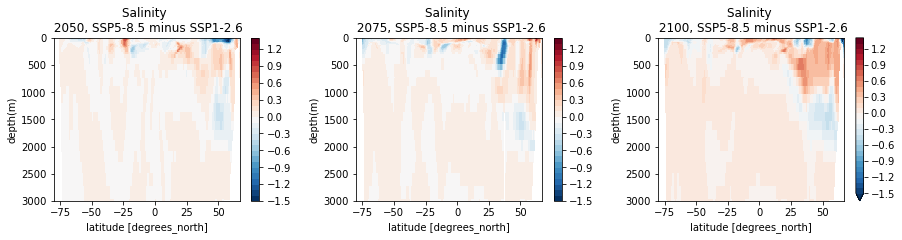

In [8]:
fig,ax=plt.subplots(1,3,figsize=(15, 3))
#plot difference in 2050
((ds_so_ssp585_cs.so - ds_so_ssp126_cs.so)[ds_so_ssp126_cs.so['time.year']==2050].mean('time').swap_dims({'j':'latitude'})
                          ).plot(ax=ax[0],levels=np.arange(-1.5,1.5,0.1),cbar_kwargs=dict(label=''))
ax[0].set_title('Salinity \n 2050, SSP5-8.5 minus SSP1-2.6')
ax[0].set_ylabel('depth(m)')
ax[0].set_ylim(3000,0)
ax[0].set_xlim(-80,67)

#plot difference in 2075
((ds_so_ssp585_cs.so - ds_so_ssp126_cs.so)[ds_so_ssp126_cs.so['time.year']==2075].mean('time').swap_dims({'j':'latitude'})
                          ).plot(ax=ax[1],levels=np.arange(-1.5,1.5,0.1),cbar_kwargs=dict(label=''))
ax[1].set_ylim(3000,0)
ax[1].set_title('Salinity \n 2075, SSP5-8.5 minus SSP1-2.6')
ax[1].set_ylabel('depth(m)')
ax[1].set_xlim(-80,67)

#plot difference in 2100
((ds_so_ssp585_cs.so - ds_so_ssp126_cs.so)[ds_so_ssp126_cs.so['time.year']==2100].mean('time').swap_dims({'j':'latitude'})
                          ).plot(ax=ax[2],levels=np.arange(-1.5,1.5,0.1),cbar_kwargs=dict(label=''))
ax[2].set_ylim(3000,0)
ax[2].set_title('Salinity \n 2100, SSP5-8.5 minus SSP1-2.6')
ax[2].set_ylabel('depth(m)')
ax[2].set_xlim(-80,67)
plt.subplots_adjust(wspace=0.3)

The two scenarios begin from identical initial conditions, with greenhouse gas emissions growing faster in SSP5-8.5 than in SSP1-2.6. Hence we expect that wet regions will be wetter dry regions will be drier to a greater extent in SSP5-8.5 than in SSP1-2.6.

In [9]:
#Define lev_bounds to be the cell edges in the vertical, and fill nans with zeros
dens126_xau = dens126_cs.assign_coords(lev_bounds = ds_thetao_ssp126.lev_bnds[:,1])
so126_xau = ds_so_ssp126_cs.assign_coords(lev_bounds = ds_so_ssp126.lev_bnds[:,1])
so126_xau['so'] = so126_xau['so'].fillna(0)

dens585_xau = dens585_cs.assign_coords(lev_bounds = ds_thetao_ssp585.lev_bnds[:,1])
so585_xau = ds_so_ssp585_cs.assign_coords(lev_bounds = ds_so_ssp585.lev_bnds[:,1])
so585_xau['so'] = so585_xau['so'].fillna(0)

### xarrayutils
In this section, we use xarrayutils to transform salinity into density space.

In [10]:
#import the package
from xarrayutils.vertical_coordinates import conservative_remap
from xarrayutils.vertical_coordinates import linear_interpolation_regrid

xarrayutils transforms salinity into density space in two steps. First, there is a regridding step, in which the depths of the density surfaces are found. 

In [11]:
#Define the densities used in the new coordinate system
t_vals = np.hstack([dens126_xau.dens.min().load().data[np.newaxis], np.arange(21.9,28, 0.1), dens126_xau.dens.max().load().data[np.newaxis]])

# define the new density grid
density_values = xr.DataArray(t_vals, coords=[('t', t_vals)]) 

#Find the depth of these surfaces in SSP1-2.6
z_dens_bounds126 = linear_interpolation_regrid(dens126_xau.lev, dens126_xau.dens, density_values, z_bounds=dens126_xau.lev_bounds.swap_dims({'lev':"lev_bounds"}) ,target_value_dim='t', z_bounds_dim='lev_bounds')

#Find the depth of these surfaces in SSP5-8.5
z_dens_bounds585 = linear_interpolation_regrid(dens585_xau.lev, dens585_xau.dens, density_values, z_bounds=dens585_xau.lev_bounds.swap_dims({'lev':"lev_bounds"}) ,target_value_dim='t', z_bounds_dim='lev_bounds')

Then there is a remapping step, in which the salinity is remapped onto these new depth levels.

In [12]:
#This section is for SSP1-2.6
#define the cell boundaries in the original salinity field
bounds_original = dens126_xau.lev_bounds.reindex(lev=np.insert(dens126_xau.lev.values,0,0), method='pad').swap_dims({'lev':"lev_bounds"}) 

# now we can remap the tracer data again (at the moment the depth dimensions have to be explicitly defined).
ds_dens_cons126 = conservative_remap(so126_xau.so.squeeze(),bounds_original, z_dens_bounds126.squeeze(),
                                   z_dim='lev', z_bnd_dim='lev_bounds', z_bnd_dim_target='regridded', mask=True
                                    ) # the associated depth dimensions for each array

# # replace the new depth dimension values with the appropriate depth (here the middle of the density cell bounds)
t_vals = z_dens_bounds126.coords['regridded'].data
t_vals = 0.5 * (t_vals[1:] + t_vals[0:-1])

ds_dens_cons126.coords['remapped'] = xr.DataArray(t_vals, coords=[('remapped', t_vals)])




#This section is for SSP5-5.8
#define the cell boundaries in the original salinity field
bounds_original = dens585_xau.lev_bounds.reindex(lev=np.insert(dens585_xau.lev.values,0,0), method='pad').swap_dims({'lev':"lev_bounds"}) 

# now we can remap the tracer data again (at the moment the depth dimensions have to be explicitly defined).
ds_dens_cons585 = conservative_remap(so585_xau.so[:,:].squeeze(),bounds_original, z_dens_bounds585.squeeze(),
                                   z_dim='lev', z_bnd_dim='lev_bounds', z_bnd_dim_target='regridded', mask=True
                                    ) # the associated depth dimensions for each array

# # replace the new depth dimension values with the appropriate depth (here the middle of the density cell bounds)
t_vals = z_dens_bounds585.coords['regridded'].data
t_vals = 0.5 * (t_vals[1:] + t_vals[0:-1])

ds_dens_cons585.coords['remapped'] = xr.DataArray(t_vals, coords=[('remapped', t_vals)])


Above we have setup the dask tree to perform this computation, but we have not loaded any data yet. We time this step, in order to assess the performance of xarrayutils.  

In [13]:
#load the difference between SSP5-5.8 and SSP1-2.6 in density space
start = time.time()
ds_dens_cons585.load();
ds_dens_cons126.load()
end = time.time()
print('It takes {:.2f} seconds to perform this transformation using xarrayutils'.format(end-start))

It takes 7.61 seconds to perform this transformation using xarrayutils


Next, we check that the depth-integrated salinity of the water column before the transformation is equal to the depth-integrated salinity of the column after the transformation. 

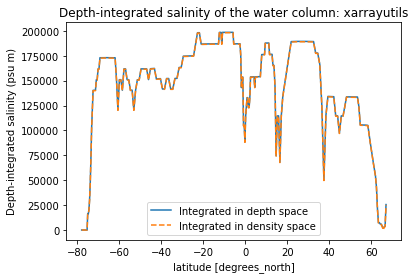

In [14]:
# find the height of the grid cells in depth space
dz_remapped126 = z_dens_bounds126.diff('regridded').rename({'regridded':'remapped'})
dz_remapped126.coords['remapped'] = ds_dens_cons126.coords['remapped']

dz_remapped585 = z_dens_bounds585.diff('regridded').rename({'regridded':'remapped'})
dz_remapped585.coords['remapped'] = ds_dens_cons585.coords['remapped']

# find the depth integrated salinity in depth space (blue line)
((so126_xau.so*ds_so_ssp126_cs.lev_bnds.diff('bnds')).sum('lev'))[2,:250,0].swap_dims({'j':'latitude'}).plot()

# find the depth integrated salinity in density space (orange dashed line)
(ds_dens_cons126*dz_remapped126).sum('remapped')[2,:250].swap_dims({'j':'latitude'}).plot(linestyle='dashed')
plt.ylabel('Depth-integrated salinity (psu m)')
plt.legend(('Integrated in depth space','Integrated in density space'))
plt.title('Depth-integrated salinity of the water column: xarrayutils');

Note that the two lines in this figure are on top of each other: the total salt content of the water column before transformation equals the total salt content of the water column after transformation.

Next, we plot the difference in the salinity in January of these years only. 

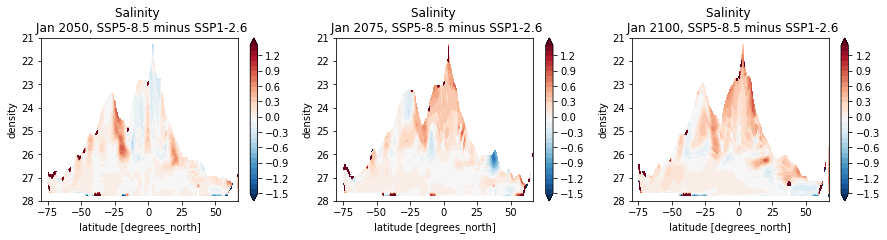

In [16]:
fig,ax = plt.subplots(1,3,figsize=(15, 3))
difference_xau = ds_dens_cons585.where(dz_remapped585>0)-ds_dens_cons126.where(dz_remapped126>0)

#plot difference in 2050
(difference_xau[(difference_xau['time.month']==1) & (difference_xau['time.year']==2050)].squeeze()
              .swap_dims({'j':'latitude'})).plot.contourf(x='latitude',y='remapped',ax=ax[0],levels=np.arange(-1.5,1.5,0.1),cmap='RdBu_r')
ax[0].set_title('Salinity \n Jan 2050, SSP5-8.5 minus SSP1-2.6')
ax[0].set_ylabel('density')
ax[0].set_ylim(28,21)
ax[0].set_xlim(-80,67)

#plot difference in 2075
(difference_xau[(difference_xau['time.month']==1) & (difference_xau['time.year']==2075)].squeeze()
              .swap_dims({'j':'latitude'})).plot.contourf(x='latitude',y='remapped',ax=ax[1],levels=np.arange(-1.5,1.5,0.1),cmap='RdBu_r')
ax[1].set_title('Salinity \n Jan 2075, SSP5-8.5 minus SSP1-2.6')
ax[1].set_ylabel('density')
ax[1].set_ylim(28,21)
ax[1].set_xlim(-80,67)

#plot difference in 2100
(difference_xau[(difference_xau['time.month']==1) & (difference_xau['time.year']==2100)].squeeze()
              .swap_dims({'j':'latitude'})).plot.contourf(x='latitude',y='remapped',ax=ax[2],levels=np.arange(-1.5,1.5,0.1),cmap='RdBu_r')
ax[2].set_title('Salinity \n Jan 2100, SSP5-8.5 minus SSP1-2.6')
ax[2].set_ylabel('density')
ax[2].set_ylim(28,21)
ax[2].set_xlim(-80,67);

One downside of this algorithm is that the remapped levels that span the boundary of the domain tend to have unrealistic values in them. This is one of the features that allows the algorithm to conserve tracer, so it is necessary. 

The plots above are difficult to read because they are only a snapshot of one month, so they contain a lot of noise due to internal variability. We would like to compare the salinities for a time mean over the whole year. However, in order to find the mean salinity in density space over the whole year, we must take the thickness-weighted average. Described in [Young 2012](https://doi.org/10.1175/JPO-D-11-0102.1), the thickness-weighted average is important for preventing relatively thin isopycnal layers from disproportionately affecting the time-mean salinity. In discretized form it follows
\begin{equation}
\tilde{S}(\rho_1 \mbox{ to } \rho_2)=\frac{\int_{t_1}^{t_2}\int_{z(\rho_1)}^{z(\rho_2)} S(z) dz \, dt}{\int_{t_1}^{t_2}\int_{z(\rho_1)}^{z(\rho_2)} dz\, dt} \, , 
\end{equation}
where $\rho_1$ and $\rho_2$ are the bounds of the isopycnal layer, and $\tilde{S}$ is the thickness weighted average salinity in density space. 

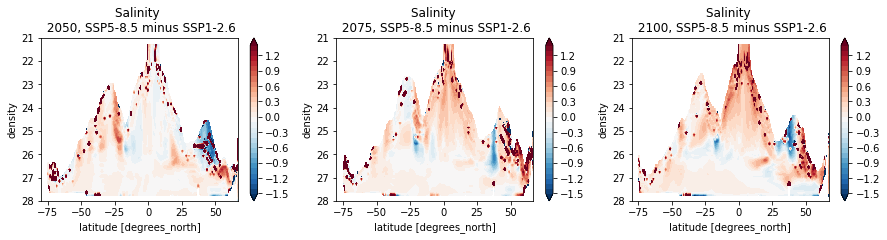

In [17]:
fig,ax = plt.subplots(1,3,figsize=(15, 3))
#plot difference in 2050
difference_tw_xau2050 = ((ds_dens_cons585*dz_remapped585)[ds_dens_cons585['time.year']==2050].sum('time')
                       /dz_remapped585[dz_remapped585['time.year']==2050].sum('time')
                 -(ds_dens_cons126*dz_remapped126)[ds_dens_cons585['time.year']==2050].sum('time')
                       /dz_remapped126[dz_remapped126['time.year']==2050].sum('time'))
(difference_tw_xau2050.swap_dims({'j':'latitude'})
       ).plot.contourf(x='latitude',y='remapped',ax=ax[0],levels=np.arange(-1.5,1.5,0.1),cmap='RdBu_r')
ax[0].set_title('Salinity \n 2050, SSP5-8.5 minus SSP1-2.6')
ax[0].set_ylabel('density')
ax[0].set_ylim(28,21)
ax[0].set_xlim(-80,67)

#plot difference in 2075
difference_tw_xau2075 = ((ds_dens_cons585*dz_remapped585)[ds_dens_cons585['time.year']==2075].sum('time')
                       /dz_remapped585[dz_remapped585['time.year']==2075].sum('time')
                 -(ds_dens_cons126*dz_remapped126)[ds_dens_cons126['time.year']==2075].sum('time')
                       /dz_remapped126[dz_remapped126['time.year']==2075].sum('time'))
(difference_tw_xau2075.swap_dims({'j':'latitude'})
             ).plot.contourf(x='latitude',y='remapped',ax=ax[1],levels=np.arange(-1.5,1.5,0.1),cmap='RdBu_r')
ax[1].set_title('Salinity \n 2075, SSP5-8.5 minus SSP1-2.6')
ax[1].set_ylabel('density')
ax[1].set_ylim(28,21)
ax[1].set_xlim(-80,67)

#plot difference in 2100
difference_tw_xau2100 = ((ds_dens_cons585*dz_remapped585)[ds_dens_cons585['time.year']==2100].sum('time')
                         /dz_remapped585[dz_remapped585['time.year']==2100].sum('time')
                 -(ds_dens_cons126*dz_remapped126)[ds_dens_cons126['time.year']==2100].sum('time')
                         /dz_remapped126[dz_remapped126['time.year']==2100].sum('time'))
(difference_tw_xau2100.swap_dims({'j':'latitude'})
             ).plot.contourf(x='latitude',y='remapped',ax=ax[2],levels=np.arange(-1.5,1.5,0.1),cmap='RdBu_r')
ax[2].set_title('Salinity \n 2100, SSP5-8.5 minus SSP1-2.6')
ax[2].set_ylabel('density')
ax[2].set_ylim(28,21);
ax[2].set_xlim(-80,67);

Unfortunately, the extreme values due to edge effects are much more visible in these average plots.

### xlayers
xlayers uses a different algorithm from xarrayutils to transform data in one vertical coordinate system into another coordinate system. Here, we apply xlayers to the same dataset in order to compare its performance and results with those of xarrayutils.

In [18]:
#Load the package
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

In [19]:
#Define cell boundaries for density field
dens126_xlay = dens126_cs.assign_coords(lev_bounds=ds_thetao_ssp126.lev_bnds)
dens585_xlay = dens585_cs.assign_coords(lev_bounds=ds_thetao_ssp585.lev_bnds)

In [20]:
#xlayers takes the locations of cell edges in a particular format, as calculated here
def finegrid_metrics(levs,lev_bnds):
    drF = np.diff(lev_bnds,axis=1)
    drC = np.concatenate((np.array([levs[0]]),np.diff(levs,axis=0),np.array([lev_bnds[-1,-1]-levs[-1]])))
    return(drF,drC)

xlayers does both regridding and remapping all in one step, but requires an initial calculation of various indices needed for binning. The output of `layers_numpy` is thickness weighted i.e. 
\begin{equation}
O(\rho_1 \mbox{ to } \rho_2)=\int_{z(\rho_1)}^{z(\rho_2)} I(z) dz \, , 
\end{equation}
where $I(z)$ is the input and $O(\rho_1 \mbox{ to } \rho_2)$ is the output in the layer between $\rho_1$ and $\rho_2$.

In [21]:
#First calculate the height of the depth cells in this simulation
fine_drf,fine_drc = finegrid_metrics(dens585_xlay.lev.values,dens585_xlay.lev_bnds.values)

#Then calculate the height of the depth cells in a new rebinned geometry, where there are ten smaller bins for each initial bin
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(fine_drf),np.squeeze(fine_drc),[fine_drf.size,10])

#define the new coordinate system (exactly as for xarrayutils)
denslayers = np.hstack([dens126_xau.dens.min().load().data[np.newaxis], np.arange(21.9,28, 0.05), 
                        dens126_xau.dens.max().load().data[np.newaxis]])

#Define function that applies xlayers to an xarray
def layers_xarray(data_in, dens_in, denslayers, mapfact, mapindex, cellindex, drf_finer, lev_name, Tlev_name):
    data_out = xr.apply_ufunc(layers_numpy, data_in, dens_in,
                       kwargs={'thetalayers':denslayers,'mapfact':mapfact,
                               'mapindex':mapindex,'cellindex':cellindex,
                               'drf_finer':drf_finer},
                       dask='parallelized', 
                       input_core_dims=[[lev_name],[lev_name]], output_core_dims=[[Tlev_name]],
                       output_dtypes=[float], output_sizes={Tlev_name:denslayers.size}
                       )
    data_out = data_out.assign_coords({Tlev_name:denslayers})
    return data_out
    

#This section is for SSP1-2.6
#Calculated the thickness-weighted salinity
sal_lay126 = layers_xarray(ds_so_ssp126_cs.so.fillna(0), dens126_xlay.dens,denslayers, 
                           mapfact, mapindex, cellindex, drf_finer, 'lev', 'Tlev')


#Calculated the thickness of each new layer (needed to back out the real salinity)
th_lay126 = layers_xarray(xr.ones_like(ds_so_ssp126_cs.so), dens126_xlay.dens,denslayers, 
                           mapfact, mapindex, cellindex, drf_finer, 'lev', 'Tlev')



#This section is for SSP5-8.5
#Calculated the thickness-weighted salinity
sal_lay585 = layers_xarray(ds_so_ssp585_cs.so.fillna(0), dens585_xlay.dens,denslayers, 
                           mapfact, mapindex, cellindex, drf_finer, 'lev', 'Tlev')

#Calculated the thickness of each new layer (needed to back out the real salinity)
th_lay585 = layers_xarray(xr.ones_like(ds_so_ssp585_cs.so), dens585_xlay.dens,denslayers, 
                           mapfact, mapindex, cellindex, drf_finer, 'lev', 'Tlev')

Again, we time the calculation of salinity in density space in order to check the performance of xlayers. In order to find the salinity in density space, we take the thickness-weighted salinity, `sal_lay` and divide by the thickness of each layer, `th_lay`.

In [22]:
#load the difference between SSP5-5.8 and SSP1-2.6 in density space
start = time.time()
sal_lay585.load()
th_lay585.load()
sal_lay126.load()
th_lay126.load()
end = time.time()
print('It takes {:.4f} seconds to perform this transformation using xlayers'.format(end-start))

It takes 0.0005 seconds to perform this transformation using xlayers


xlayers generally takes between 0.0004 and 0.01 seconds to transform this salinity field into density coordinates. In other words xlayers is at least 1000x faster than xarrayutils.

Again, we confirm that this algorithm conserves ocean properties checking that the depth-integrated salinity before transformation is equal to the depth-itegrated salinity after the transformation. 

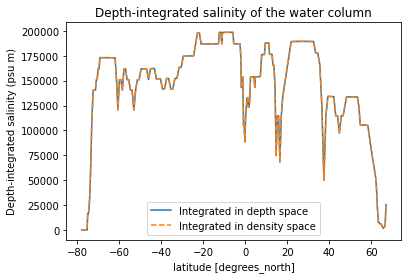

In [23]:
# find the depth integrated salinity in depth space (blue line)
((so126_xau.so*ds_so_ssp126_cs.lev_bnds.diff('bnds')).sum('lev'))[0,:250].swap_dims({'j':'latitude'}).plot()

# find the depth integrated salinity in density space (orange dashed line)
sal_lay126.sum('Tlev')[0,:250].swap_dims({'j':'latitude'}).plot(linestyle='--')
plt.title('Salt content of the water column')
plt.ylabel('Depth-integrated salinity (psu m)')
plt.legend(('Integrated in depth space','Integrated in density space'))
plt.title('Depth-integrated salinity of the water column');

The orange dashed line is on top of the blue line, indicating that the total salt content of the water column before the transformation into density space equals the total salt content of the water column after transformation into density space.

We compare the thickness weighted time-mean salinity in density space between the two experiments.

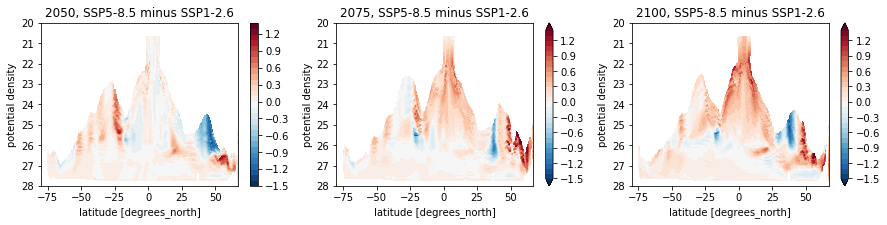

In [24]:
#Find the thickness weighted difference between the two experiments
difference_tw_xlay2050 = (sal_lay585[sal_lay585['time.year']==2050].sum('time')/th_lay585[th_lay585['time.year']==2050].sum('time')
                          -sal_lay126[sal_lay126['time.year']==2050].sum('time')/th_lay126[th_lay126['time.year']==2050].sum('time'))

difference_tw_xlay2075 = (sal_lay585[sal_lay585['time.year']==2075].sum('time')/th_lay585[th_lay585['time.year']==2075].sum('time')
                          -sal_lay126[sal_lay126['time.year']==2075].sum('time')/th_lay126[th_lay126['time.year']==2075].sum('time'))

difference_tw_xlay2100 = (sal_lay585[sal_lay585['time.year']==2100].sum('time')/th_lay585[th_lay585['time.year']==2100].sum('time')
                          -sal_lay126[sal_lay126['time.year']==2100].sum('time')/th_lay126[th_lay126['time.year']==2100].sum('time'))

fig,ax = plt.subplots(1,3,figsize=(15, 3))

#plot difference in 2050
(difference_tw_xlay2050.swap_dims({'j':'latitude'})
                  ).plot.contourf(x='latitude',y='Tlev',levels=np.arange(-1.5,1.5,0.1),ax=ax[0])
ax[0].set_title('2050, SSP5-8.5 minus SSP1-2.6')
ax[0].set_ylabel('potential density')
ax[0].set_ylim(28,20)
ax[0].set_xlim(-80,67)

#plot difference in 2075
(difference_tw_xlay2075.swap_dims({'j':'latitude'})
                 ).plot.contourf(x='latitude',y='Tlev',levels=np.arange(-1.5,1.5,0.1),ax=ax[1])
ax[1].set_title('2075, SSP5-8.5 minus SSP1-2.6')
ax[1].set_ylabel('potential density')
ax[1].set_ylim(28,20)
ax[1].set_xlim(-80,67)

#plot difference in 2100
(difference_tw_xlay2100.swap_dims({'j':'latitude'})
                ).plot.contourf(x='latitude',y='Tlev',levels=np.arange(-1.5,1.5,0.1),ax=ax[2])
ax[2].set_title('2100, SSP5-8.5 minus SSP1-2.6')
ax[2].set_ylabel('potential density')
ax[2].set_ylim(28,20)
ax[2].set_xlim(-80,67);

In the right two panels, lighter waters (which are found in the tropics and subtropics) are saltier in SSP5-8.5 than in SSP1-2.6. Waters formed in the subpolar regions (with potential densities between 25.5 and 27)are fresher in SSP5-8.5 than in SSP1-2.6. This is consistent with previous work that suggests that wet regions get wetter and dry regions get drier as greenhouse gas levels in the atmosphere increase. 

### Conclusions
We transform salinity from the ACCESS model into density coordinates using two different property-conserving algorithms, xarrayutils and xlayers. Xlayers is about 100x faster than xarrayutils, but xarrayutils is easier to set up because it does not require a FORTRAN compiler. The salinity in isopycnal space is similar between the two algorithms.

 In general the subtropics has net evaporation, i.e. it is a dry region, and the subpolar region has net precipitation, i.e. it is a wetter region. As greenhouse gas levels increase, wet regions are genreally thought to get wetter and dry regions are thought to get drier (see e.g. [Vallis et al. 2015](https://doi.org/10.1002/qj.2456)). Using output from two scenarios in the ACCESS model, we show here that the salinity in density space is consistent with this "wet gets wetter and dry gets drier" hypothesis: for scenarios with more greenhouse gases in the atmosphere, higher salinities are seen in the tropics and lower salinities are seen in the subtropics. 